### 模型选择、欠拟合和过拟合

#### 通过多项式拟合来交互探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小 （测试集为验证集）
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6885],
         [-0.7421]]),
 tensor([[ 1.0000e+00, -6.8852e-01,  2.3703e-01, -5.4400e-02,  9.3638e-03,
          -1.2894e-03,  1.4797e-04, -1.4554e-05,  1.2526e-06, -9.5825e-08,
           6.5977e-09, -4.1297e-10,  2.3695e-11, -1.2549e-12,  6.1718e-14,
          -2.8329e-15,  1.2191e-16, -4.9374e-18,  1.8886e-19, -6.8439e-21],
         [ 1.0000e+00, -7.4206e-01,  2.7533e-01, -6.8104e-02,  1.2634e-02,
          -1.8751e-03,  2.3191e-04, -2.4584e-05,  2.2804e-06, -1.8802e-07,
           1.3952e-08, -9.4124e-10,  5.8205e-11, -3.3224e-12,  1.7610e-13,
          -8.7121e-15,  4.0406e-16, -1.7637e-17,  7.2712e-19, -2.8398e-20]]),
 tensor([3.1924, 2.8749]))

### 对模型进行训练和测试

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    # 单层的线性网络
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    # 扫一遍数据
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合

weight: [[ 4.987971   1.189474  -3.3837085  5.6081066]]


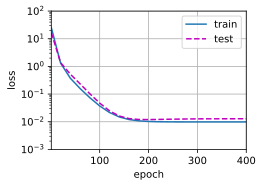

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数欠拟合

weight: [[2.667232  4.4028707]]


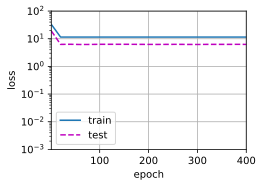

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合 过拟合

weight: [[ 4.9823222e+00  1.2708287e+00 -3.3847711e+00  5.1985364e+00
   1.6732146e-03  1.1327100e+00  6.0619280e-02  1.0999051e-01
   1.4019741e-01 -1.7448318e-01  4.2156331e-02 -1.2833522e-01
  -2.0525852e-01 -2.1166462e-01  1.4809966e-01  2.1477470e-01
   2.8552886e-02 -2.0364013e-01  2.0931157e-01 -1.2684816e-01]]


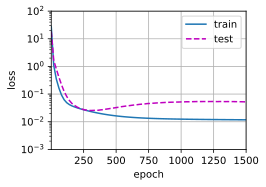

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)